## Определение стоимости автомобилей

### Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.  
Критерии, которые важны заказчику:  
- качество предсказания;
- время обучения модели;
- время предсказания модели.

### Основные шаги:
1. Загрузите данные, путь к файлу: /datasets/autos.csv.  
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

### Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

### Описание данных
Данные находятся в файле /datasets/autos.csv    

**Признаки**    
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

**Целевой признак**  
- Price — цена (евро)

### 1. Подготовка данных

**Импорт библиотек**

In [1]:
!pip install missingno
!pip install phik
!pip install scikit-learn==1.1.3
!pip install catboost
!pip install lightgbm

In [2]:
!pip install category_encoders

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import plotly.figure_factory as ff
import phik
import lightgbm as lgb
import catboost as cb
import category_encoders as ce

from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from catboost import CatBoostClassifier
from catboost import cv, Pool
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

**Настройки**

In [4]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('C:/Users/sazon/Desktop/Задачи/YandexPracticum/autos.csv')

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Заметил следующее:**  
- Пропуски в слобцах VehicleType, Gearbox, Model, FuelType, Repaired.
- Ненужные стобцы DateCrawled, PostalCode, LastSeen, DateCreated, NumberOfPictures(Все значения нули). Удалим их.  
- Категориальные признаки VehicleType, Gearbox, Model, FuelType, Brand, Repaired.

### 2. Предобработка данных

**Удалим ненужные столбцы**

In [9]:
df.drop(['DateCrawled', 'PostalCode', 'LastSeen', 'DateCreated', 'NumberOfPictures'], axis='columns', inplace=True)

**Работа с пропусками**

In [10]:
print('\nПропусков в данных\n')
print(df.isna().sum())


Пропусков в данных

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64


**Процент пропущенных данных**

In [11]:
(df.isna().sum() / len(df)).round(4) * 100

Price                0.00
VehicleType         10.58
RegistrationYear     0.00
Gearbox              5.60
Power                0.00
Model                5.56
Kilometer            0.00
RegistrationMonth    0.00
FuelType             9.28
Brand                0.00
Repaired            20.08
dtype: float64

**Используем библиотеку missingno, которая предоставляет удобные средства для визуальной оценки пропусков.**

In [12]:
sns.set()

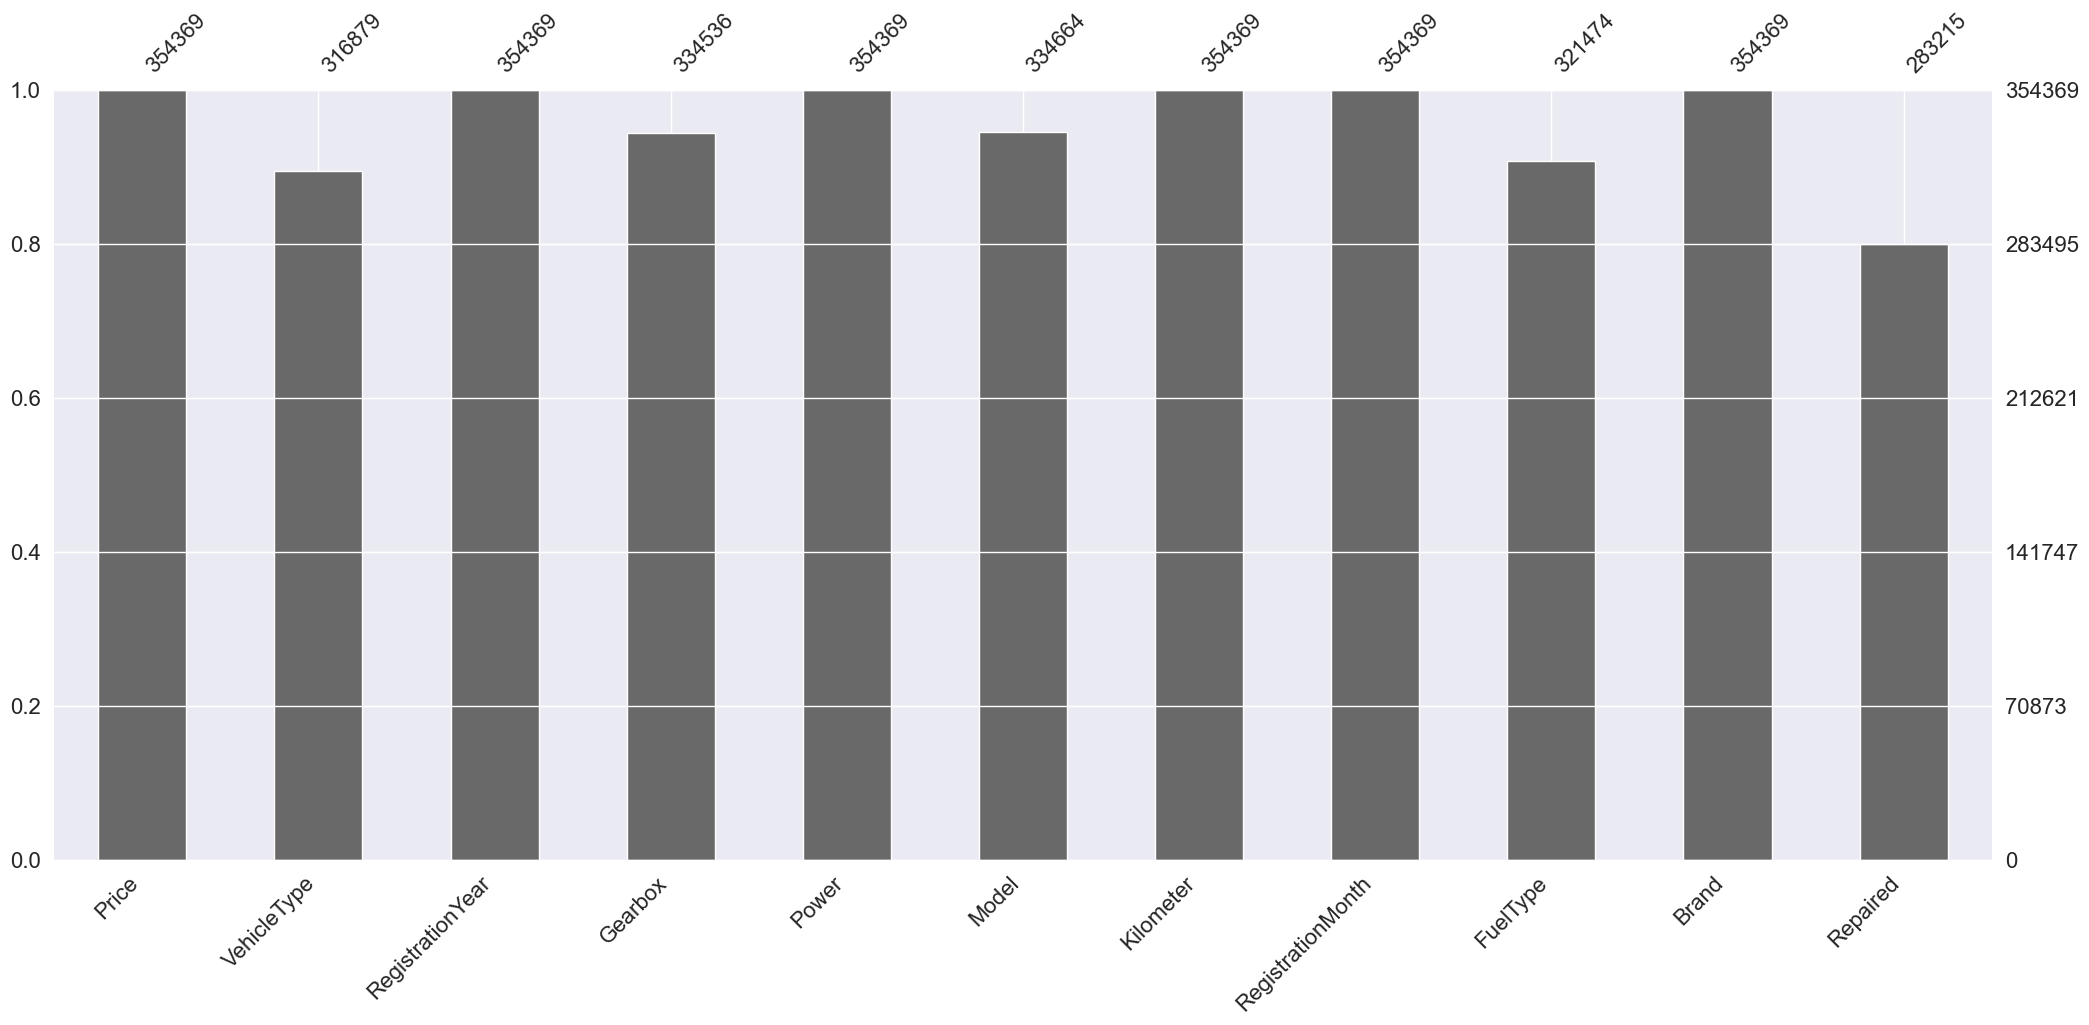

In [13]:
msno.bar(df)
plt.show()

**Столбчатая диаграмма не дает информации о том, где именно больше всего пропущенных значений, для этого подойдет матрица пропущенных значений.**

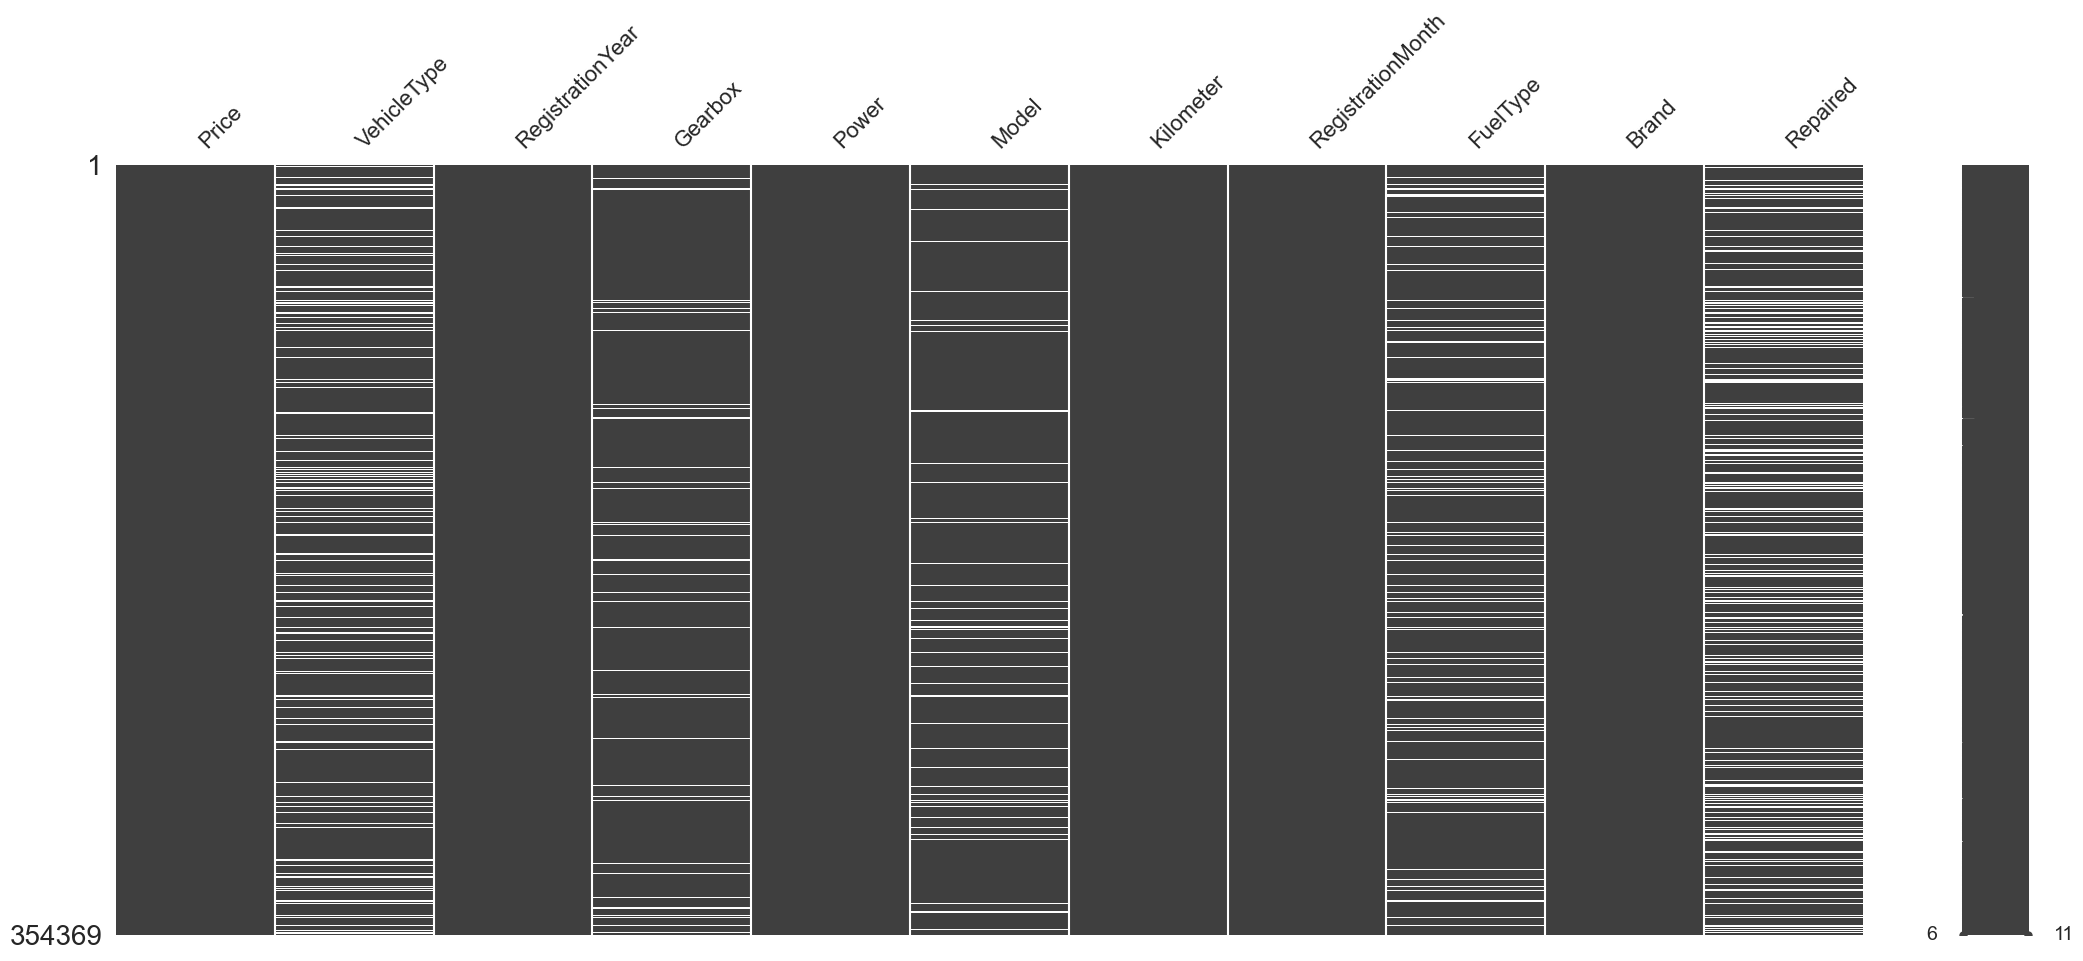

In [14]:
msno.matrix(df)
plt.show()

**Распределение пропущенных значений в датасете выглядит случайным, закономерностью были бы пропуски, например, только в первой половине наблюдений.**

**Так как пропуски в нашем датасете исключительно в категориальных стобцах, заменим их на самые популярные значения.**

**Функция для поиска значения с наибольшей частотой в столбце**

In [15]:
def most_frequent_value(column):
    return column.value_counts().idxmax()

VehicleType = most_frequent_value(df['VehicleType'])
Gearbox = most_frequent_value(df['Gearbox'])
Model = most_frequent_value(df['Model'])
FuelType = most_frequent_value(df['FuelType'])
Repaired = most_frequent_value(df['Repaired'])

print(f'Наиболее частое значение в столбце VehicleType: {VehicleType}')
print(f'Наиболее частое значение в столбце Gearbox: {Gearbox}')
print(f'Наиболее частое значение в столбце Model: {Model}')
print(f'Наиболее частое значение в столбце FuelType: {FuelType}')
print(f'Наиболее частое значение в столбце Repaired: {Repaired}')

Наиболее частое значение в столбце VehicleType: sedan
Наиболее частое значение в столбце Gearbox: manual
Наиболее частое значение в столбце Model: golf
Наиболее частое значение в столбце FuelType: petrol
Наиболее частое значение в столбце Repaired: no


**Создаем экземпляр SimpleImputer с стратегией "most_frequent" и заменяем пропущенные значения в столбцах**

In [16]:
imputer = SimpleImputer(strategy='most_frequent')

columns_to_impute = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [17]:
print('\nПропусков в данных\n')
print(df.isna().sum())


Пропусков в данных

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64


**Работа с дубликатами**

In [18]:
print(f'\nЯвных дубликатов в данных: {df.duplicated().sum()}')


Явных дубликатов в данных: 33266


In [19]:
df.shape

(354369, 11)

**Удалим явные дубликаты, так как я удалил столбцы с датами загрузки и выгрузки анкет автомобилей, есть вероятность, что владельцы заводили несколько анкет.**

In [20]:
df = df.drop_duplicates ()

In [21]:
print(f'\nЯвных дубликатов в данных: {df.duplicated().sum()}')


Явных дубликатов в данных: 0


In [22]:
df.shape

(321103, 11)

**Проверим категориальные столбцы на скрытые дубликаты**

In [23]:
categorical_columns = df.loc[:,  (df.dtypes == 'object')].columns

In [24]:
datas = [df] 
for data in datas:
    for column in categorical_columns:
        print(sorted(data[column].unique()))
        print(f'Количество уникальных значений {column}:', data[column].nunique())

['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
Количество уникальных значений VehicleType: 8
['auto', 'manual']
Количество уникальных значений Gearbox: 2
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 

**Скрытых дубликатов не обнаружил.**

**Посмотрим есть ли статистические выбросы.**

**Выведем описание всего датасета методом describe():**

In [25]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,"321,103.00","321,103.00","321,103.00","321,103.00","321,103.00"
mean,"4,425.94","2,004.26",110.62,"128,010.81",5.71
std,"4,528.22",91.84,197.44,"38,030.59",3.72
min,0.00,"1,000.00",0.00,"5,000.00",0.00
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00


**Аномальные значение присутствуют в :**
- Price - минимальное значение 0, если автомобиль и вправду отдают даром, нам это не подходит, нам нужно предсказать цену;
- RegistrationYear - минимум 1000-й год, максимум 9999-й год;
- Power	 - минимум 0, максимум 20к возможна опечатка, потому что я больше 295 л.с. не нашел автомобилей;
- RegistrationMonth - месяц регистрации 0.  
Посмотрим на графиках и поработаем с выбросами.

**Столбец Price**

**Количественные данные**

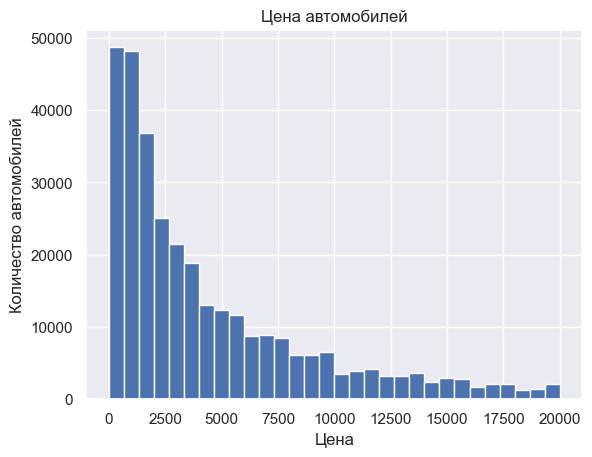

count   321,103.00
mean      4,425.94
std       4,528.22
min           0.00
25%       1,050.00
50%       2,700.00
75%       6,400.00
max      20,000.00
Name: Price, dtype: float64

In [26]:
plt.hist(df['Price'], bins=30)
plt.title('Цена автомобилей')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.show()

df['Price'].describe()

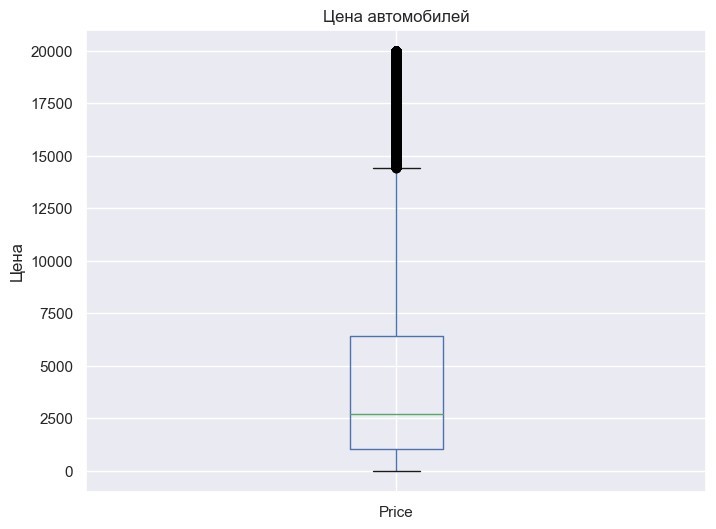

In [27]:
df['Price'].plot(kind='box', figsize=(8, 6))
plt.title('Цена автомобилей')
plt.ylabel('Цена')
plt.show()

In [28]:
df.query('Price == 0').shape[0]

8946

**8946 автомобилей за бесплатно, вот это да! Я считаю, что лучше заменить на медианное значение там где цена меньше 100.**

In [29]:
median_price = df['Price'].median()
df.loc[df['Price'] < 100, 'Price'] = median_price

**Столбец RegistrationYear**

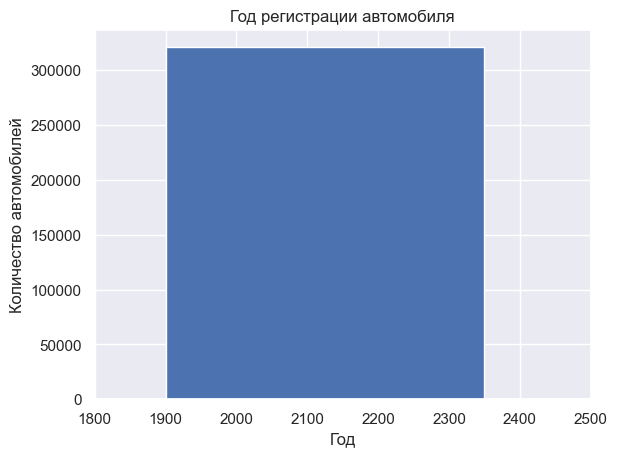

count   321,103.00
mean      2,004.26
std          91.84
min       1,000.00
25%       1,999.00
50%       2,003.00
75%       2,008.00
max       9,999.00
Name: RegistrationYear, dtype: float64

In [30]:
plt.hist(df['RegistrationYear'], bins=20)
plt.title('Год регистрации автомобиля')
plt.xlabel('Год')
plt.xlim(1800, 2500)
plt.ylabel('Количество автомобилей')
plt.show()

df['RegistrationYear'].describe()

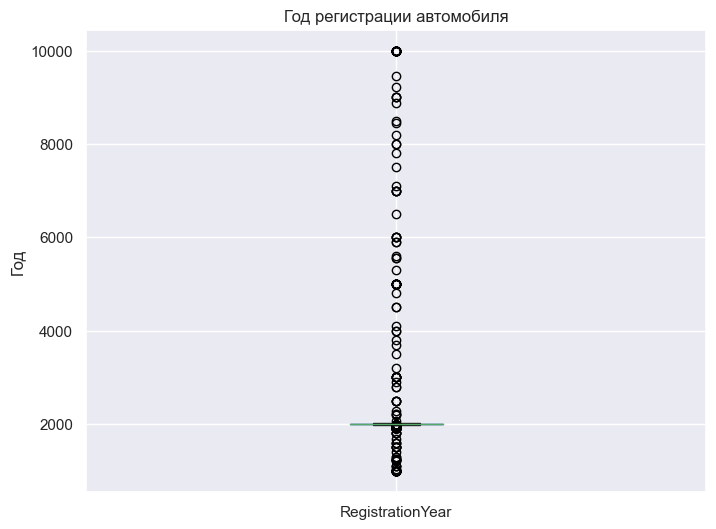

In [31]:
df['RegistrationYear'].plot(kind='box', figsize=(8, 6))
plt.title('Год регистрации автомобиля')
plt.ylabel('Год')
plt.show()

In [32]:
df.query('RegistrationYear > 2023').shape[0]

99

In [33]:
df.query('RegistrationYear < 1930').shape[0]

159

**Давайте будущие космолеты и древние мамонтоходы удалим из нашего датафрейма**

In [34]:
df.drop(df.query('RegistrationYear > 2023').index, inplace=True)

In [35]:
df.drop(df.query('RegistrationYear < 1930').index, inplace=True)

**Столбец Power**

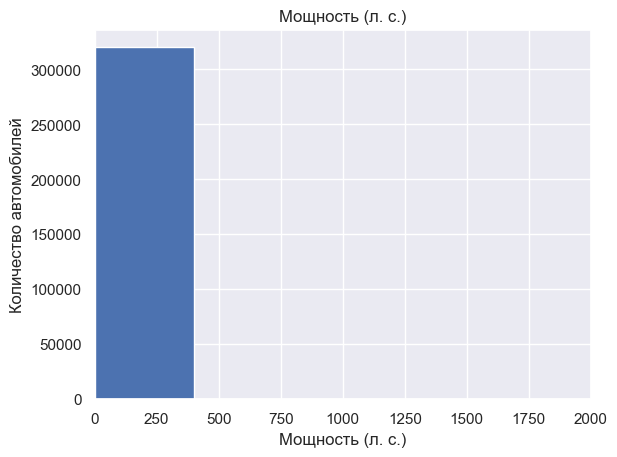

count   320,845.00
mean        110.63
std         197.14
min           0.00
25%          69.00
50%         105.00
75%         143.00
max      20,000.00
Name: Power, dtype: float64

In [36]:
plt.hist(df['Power'], bins=50)
plt.title('Мощность (л. с.)')
plt.xlabel('Мощность (л. с.)')
plt.xlim(0, 2000)
plt.ylabel('Количество автомобилей')
plt.show()

df['Power'].describe()

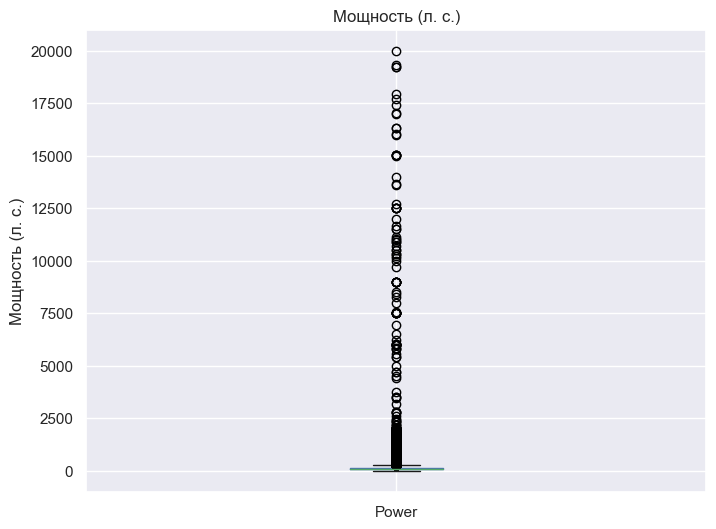

In [37]:
df['Power'].plot(kind='box', figsize=(8, 6))
plt.title('Мощность (л. с.)')
plt.ylabel('Мощность (л. с.)')
plt.show()

**Самым мощным грузовым автомобилем в мире считается американский карьерный самосвал Caterpillar 797F — огромная машина, мощностью 4000 лошадиных сил**

In [38]:
df.query('Power > 1000').shape[0]

290

In [39]:
df.query('Power < 50').shape[0]

41347

**Считаю что те данные, где больше 1000 л.с. и меньше 50 заменим на медианное значение.**

In [40]:
median_price = df['Power'].median()
df.loc[df['Power'] > 1000, 'Power'] = median_price

In [41]:
median_price = df['Power'].median()
df.loc[df['Power'] < 50, 'Power'] = median_price

In [42]:
df['Power'].describe()

count   320,845.00
mean        119.76
std          51.03
min          50.00
25%          89.00
50%         105.00
75%         141.00
max       1,000.00
Name: Power, dtype: float64

**Столбец Kilometer**

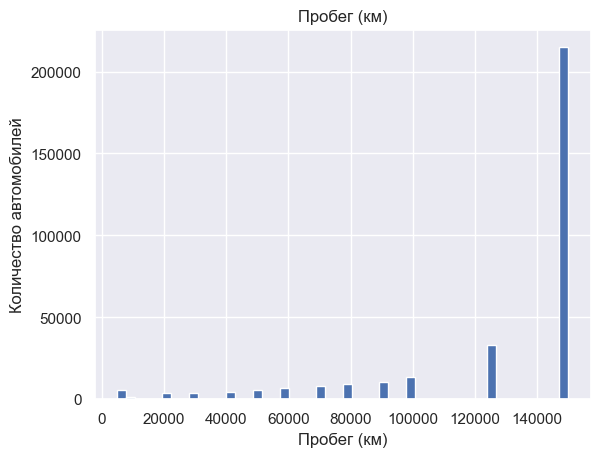

count   320,845.00
mean    128,088.30
std      37,917.84
min       5,000.00
25%     125,000.00
50%     150,000.00
75%     150,000.00
max     150,000.00
Name: Kilometer, dtype: float64

In [43]:
plt.hist(df['Kilometer'], bins=50)
plt.title('Пробег (км)')
plt.xlabel('Пробег (км)')
plt.ylabel('Количество автомобилей')
plt.show()

df['Kilometer'].describe()

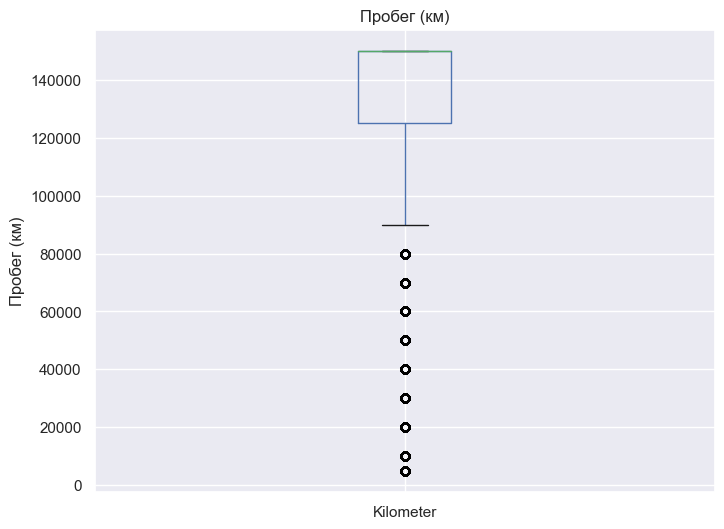

In [44]:
df['Kilometer'].plot(kind='box', figsize=(8, 6))
plt.title('Пробег (км)')
plt.ylabel('Пробег (км)')
plt.show()

**Столбец RegistrationMonth**

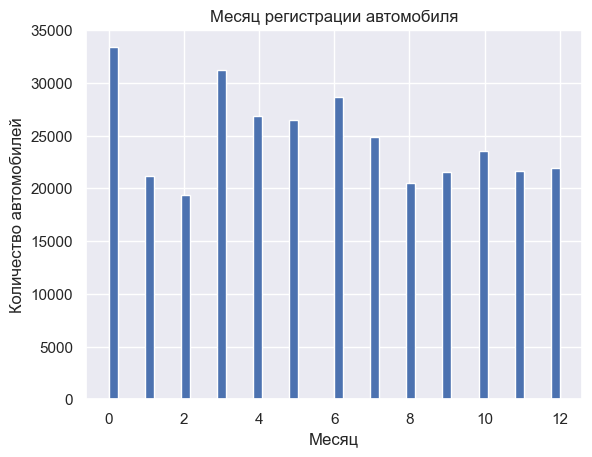

count   320,845.00
mean          5.71
std           3.72
min           0.00
25%           3.00
50%           6.00
75%           9.00
max          12.00
Name: RegistrationMonth, dtype: float64

In [45]:
plt.hist(df['RegistrationMonth'], bins=50)
plt.title('Месяц регистрации автомобиля')
plt.xlabel('Месяц')
plt.ylabel('Количество автомобилей')
plt.show()

df['RegistrationMonth'].describe()

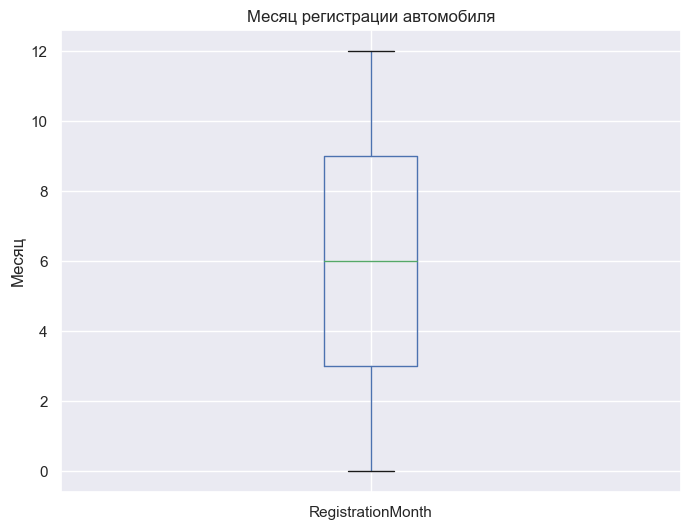

In [46]:
df['RegistrationMonth'].plot(kind='box', figsize=(8, 6))
plt.title('Месяц регистрации автомобиля')
plt.ylabel('Месяц')
plt.show()

**Тут думаю просто не написали месяц регистрации, заменим на медианное значение.**

In [47]:
median_price = df['RegistrationMonth'].median()
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = median_price

**Категориальные данные**

In [48]:
def make_barbplot(column, title):
    fig, ax = plt.subplots(figsize=(12, 5))
    pivot = pd.DataFrame(df.pivot_table(index=column, aggfunc="size").sort_values(ascending=False)).head(10)
    
    sns.barplot(data=pivot, x=0, y=pivot.index)
    ax.set_title(title)
    plt.xlabel('Количество')
    plt.show()

**Столбец VehicleType**

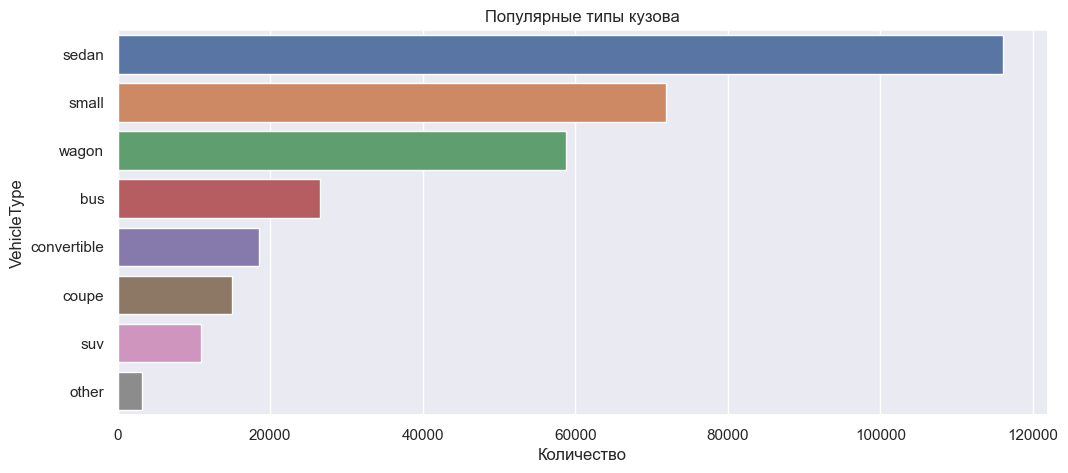

In [49]:
make_barbplot('VehicleType', 'Популярные типы кузова')

**Столбец Gearbox**

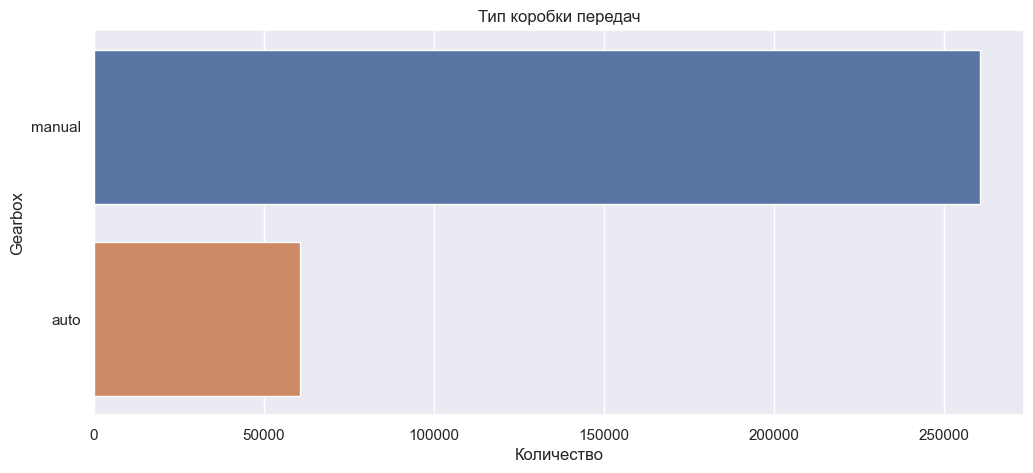

In [50]:
make_barbplot('Gearbox', 'Тип коробки передач')

**Столбец FuelType**

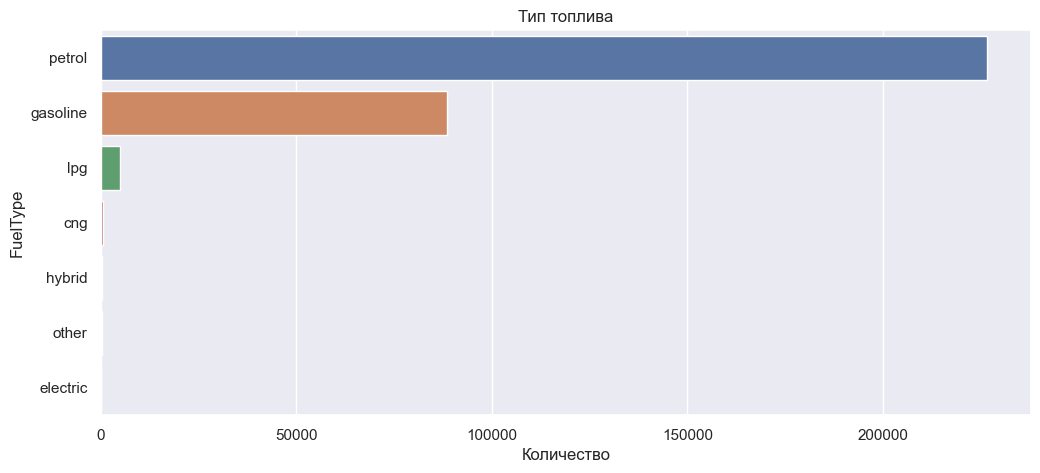

In [51]:
make_barbplot('FuelType', 'Тип топлива')

**Столбец Repaired**

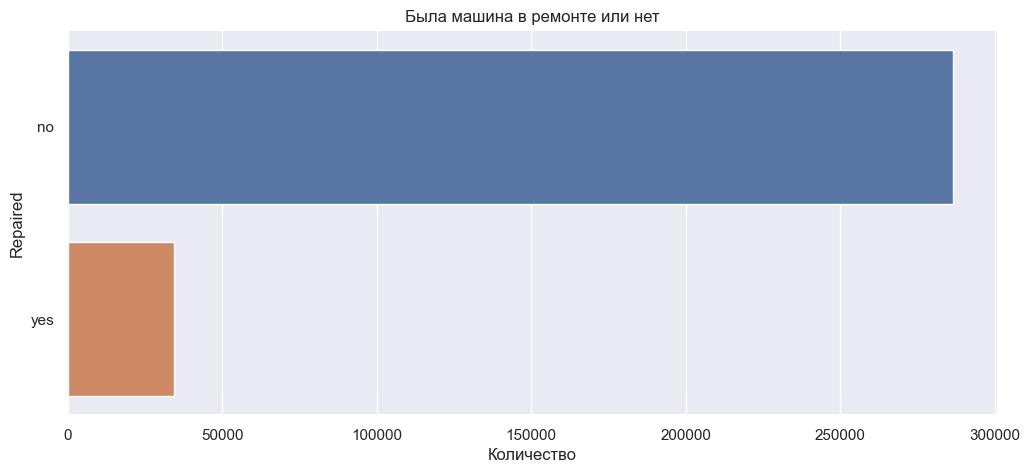

In [52]:
make_barbplot('Repaired', 'Была машина в ремонте или нет')

**Стобец Brand**

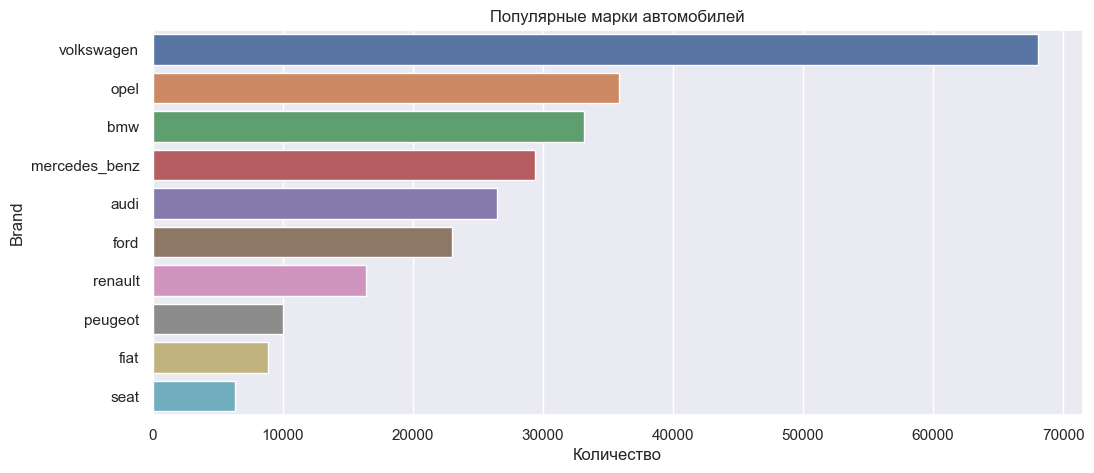

In [53]:
make_barbplot('Brand', 'Популярные марки автомобилей')

**Столбец Model**

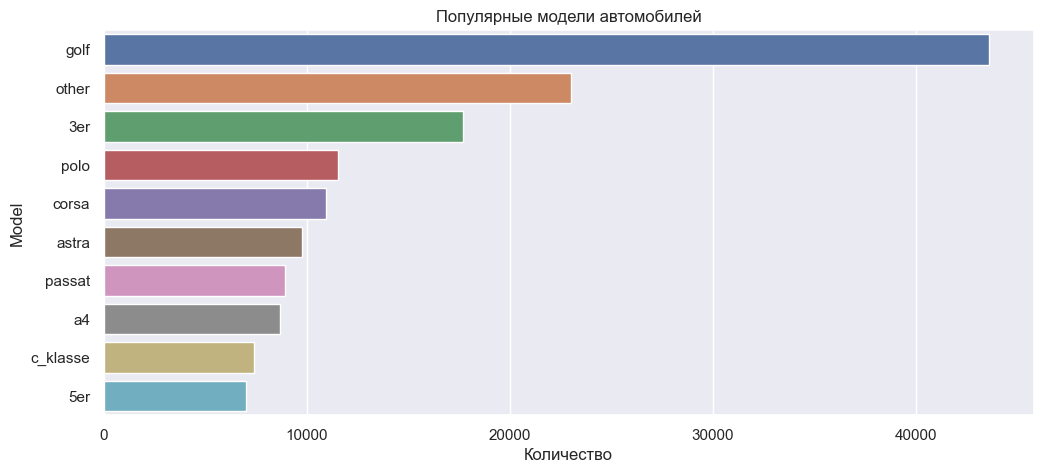

In [54]:
make_barbplot('Model', 'Популярные модели автомобилей')

**Анализ корреляции будем выполнять с помощью библиотеки Phik.**

In [55]:
df.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Price,1.00,0.26,0.57,0.32,0.42,0.57,0.31,0.13,0.25,0.35,0.27
VehicleType,0.26,1.00,0.24,0.26,0.27,0.89,0.17,0.09,0.31,0.61,0.06
RegistrationYear,0.57,0.24,1.00,0.13,0.18,0.57,0.31,0.13,0.26,0.37,0.14
Gearbox,0.32,0.26,0.13,1.00,0.52,0.61,0.02,0.07,0.15,0.50,0.03
Power,0.42,0.27,0.18,0.52,1.00,0.63,0.07,0.07,0.14,0.47,0.05
Model,0.57,0.89,0.57,0.61,0.63,1.00,0.43,0.15,0.52,1.00,0.12
Kilometer,0.31,0.17,0.31,0.02,0.07,0.43,1.00,0.05,0.14,0.27,0.09
RegistrationMonth,0.13,0.09,0.13,0.07,0.07,0.15,0.05,1.00,0.08,0.09,0.05
FuelType,0.25,0.31,0.26,0.15,0.14,0.52,0.14,0.08,1.00,0.30,0.03
Brand,0.35,0.61,0.37,0.50,0.47,1.00,0.27,0.09,0.30,1.00,0.08


In [56]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


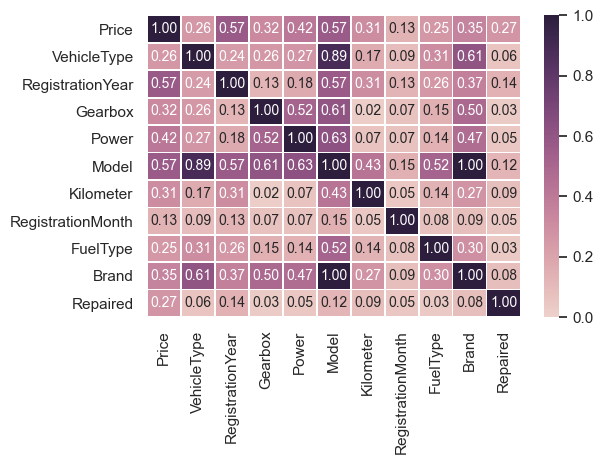

In [57]:
sns.heatmap(phik_overview,
                        vmin=0, vmax=1,
                    annot = True,
                annot_kws = {"size":10}, 
                cmap=sns.cubehelix_palette(as_cmap=True), 
                fmt='.2f',  linewidth=.5)
plt.tight_layout()

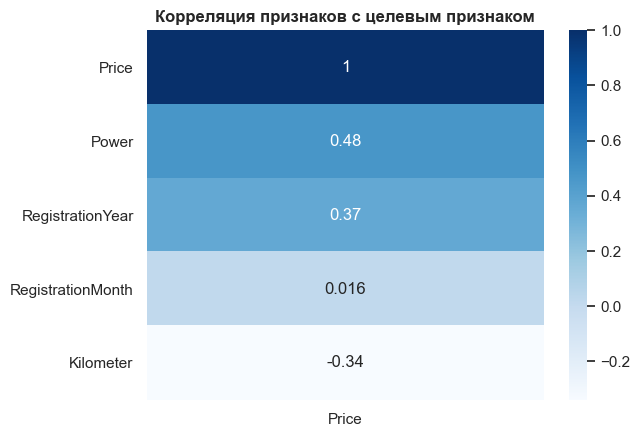

In [58]:
datas = [df]
AX = 0
for data in datas:
    sns.heatmap(df.corr()[['Price']].sort_values('Price', ascending=False),
                annot = True, annot_kws = {"size":12}, cmap='Blues')
    plt.title("Корреляция признаков с целевым признаком", fontweight="bold")
    AX += 1
    plt.show()

### Выводы:  
- Удалили ненужные столбцы;
- Обработали пропущенные значения с помощью SimpleImputer и заменили пропуски на наиболее частое значение;
- Удалили явные дубликаты;
- В столбце Price заменили значения меньше 100 на медианну;
- В столбце RegistrationYear удалили нереальные значения;
- В столбце Power заменили нереальные значения на медианну;
- В столбце RegistrationMonth заменили нулевой месяц на медиану;
- Самый популярный кузов sedan;
- Самая популярная коробка передач manual;
- Большинство автомобили на бензине;
- Большинство автомобили не были в ремонте;
- Самая популярная марка автомобиля volkswagen;
- Самая популярная модель golf;
- Увидели корреляцию столбцов Power(0.48), RegistrationYear(0.37) и Model(0.57) с целевым признаком.

### 3. Подготовка датафрейма для создания моделей машинного обучения

**Разделяем на признаки**

In [59]:
features = df.drop('Price', axis = 1)
target = df['Price']

**Делим наши признаки на тренировочную, валидационную и тестовую выборку.**

In [60]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.40, random_state=12345
)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.50, random_state=12345
)

In [61]:
print('Разделение выборки в следующих пропорциях:')
print(f'{(len(features_train)/len(df)):.0%} — тренировочная;')
print(f'{(len(features_test)/len(df)):.0%} — тестовая;')
print(f'{(len(features_valid)/len(df)):.0%} — валидационная.')

Разделение выборки в следующих пропорциях:
60% — тренировочная;
20% — тестовая;
20% — валидационная.


**Кодируем методом TargetEncoder**

In [62]:
encoder = ce.TargetEncoder()

features_train_te = encoder.fit_transform(features_train, target_train)
features_test_te = encoder.transform(features_test)
features_valid_te = encoder.transform(features_valid)

**Масштабируем данные методом StandardScaler**

In [63]:
numeric = [*features_train.select_dtypes(exclude=['object']).columns]
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [64]:
features_test_te.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
178770,"4,200.30",2016,"3,980.99",58.00,"1,489.22",150000,6.00,"3,711.06","2,401.24","4,813.74"
269833,"4,952.17",2004,"3,980.99",75.00,"4,104.41",125000,6.00,"3,711.06","5,998.99","4,813.74"
177047,"6,150.90",2002,"6,850.54",105.00,"3,928.71",150000,6.00,"3,711.06","5,962.86","4,813.74"
68066,"4,952.17",2008,"6,850.54",120.00,"3,097.36",150000,7.00,"6,621.97","2,861.95","4,813.74"
161912,"2,760.22",2003,"3,980.99",75.00,"2,241.03",125000,7.00,"3,711.06","2,401.24","4,813.74"


### 4. Обучение моделей

**Я решил сделать следующее:**  
1. модель LightGBM с подбором параметров GridSearchCV и с TargetEncoder;
2. модель CatBoost с подбором параметров GridSearchCV и с TargetEncoder;
3. модель DesicionTree с подбором параметров GridSearchCV и с TargetEncoder;


**Хотел сделать еще на Optuna, но очень долго считает, поэтому убрал.**

**модель LightGBM с подбором параметров GridSearchCV и с TargetEncoder**

In [68]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]


clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_te, target_train)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 154005, number of used features: 10
[LightGBM] [Info] Start training from score 4524.427298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 154005, number of used features: 10
[LightGBM] [Info] Start training from score 4523.729515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

1711.0703076243717

In [76]:
%%time

model_lgbmr = LGBMRegressor(learning_rate= 0.1, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_te, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 192507, number of used features: 10
[LightGBM] [Info] Start training from score 4525.233888
CPU times: total: 8.72 s
Wall time: 1.41 s


LGBMRegressor(num_leaves=200, random_state=12345)

In [77]:
%%time

target_predict = model_lgbmr.predict(features_valid_te)

CPU times: total: 641 ms
Wall time: 114 ms


**модель CatBoost с подбором параметров GridSearchCV и с TargetEncoder**

In [79]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_te, target_train)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_te = (max(mts) * -1) ** .5
gscv_rsme_cbr_te

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: total: 2min 4s
Wall time: 2min 47s


1731.840873108063

In [80]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False)
model_cbr.fit(features_train_te, target_train)

CPU times: total: 12.5 s
Wall time: 12.3 s


In [81]:
%%time

target_predict = model_cbr.predict(features_valid_te)

CPU times: total: 31.2 ms
Wall time: 26.3 ms


**модель DesicionTree с подбором параметров GridSearchCV и с TargetEncoder**

In [82]:
%%time

model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(features_train_te, target_train)

best_model = grid_search.best_estimator_

predictions_valid = best_model.predict(features_valid_te)
rmse_valid = np.sqrt(mean_squared_error(target_valid, predictions_valid))
print(best_model)
print("RMSE на валидационной выборке:", rmse_valid)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4)
RMSE на валидационной выборке: 2020.0486711073834
CPU times: total: 10.1 s
Wall time: 40.4 s


In [83]:
%%time

model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=4)
model.fit(features_train_te, target_train)

CPU times: total: 578 ms
Wall time: 1.56 s


DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=4)

In [84]:
%%time

predictions_valid = best_model.predict(features_valid_te)

CPU times: total: 0 ns
Wall time: 26.5 ms


### 5. Анализ моделей

Итак лучшая модель LightGBM c результатами:
- время обучения на тренировочной выборке - 1.41 с
- время предсказания на валидационной выборке - 114 мс
- RMSE - 1711

**Проведем тестирование лучшей модели на тестовой выборке.**

In [85]:
%%time

model_lgbmr = LGBMRegressor(learning_rate= 0.1, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_te, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 192507, number of used features: 10
[LightGBM] [Info] Start training from score 4525.233888
CPU times: total: 8.97 s
Wall time: 1.42 s


LGBMRegressor(num_leaves=200, random_state=12345)

In [86]:
%%time

target_predict_te = model_lgbmr.predict(features_test_te)

CPU times: total: 641 ms
Wall time: 114 ms


In [87]:
final_rsme_lgbmr_te = mean_squared_error(target_test, target_predict_te) ** .5
final_rsme_lgbmr_te

1716.2399939225668

**Мы провели анализ и обработку данных. Подготовили их и обучили модели на их основе. Нашли лучшие гиперпараметры для моделей и протестировали их на тестовой выборке, применив метрику RMSE.**

In [88]:
results = {
    'Model' : ['LightGBM', 'Catboost', 'DesicionTree'],
    'Valid RMSE' :pd.Series([1711, 1731, 2020]),
    'Fit train time, sec': pd.Series(['1.41 с', '12.3 с.', '1.56 мс.']),
    'Predict valid time, sec': pd.Series(['114 мс.', '26.3 мс.', '26.5 мс.']),
    'Test RMSE' :pd.Series([1716]),
    }
display(pd.DataFrame(results))

,Model,Valid RMSE,"Fit train time, sec","Predict valid time, sec",Test RMSE
0,LightGBM,1711,1.41 с,114 мс.,"1,716.00"
1,Catboost,1731,12.3 с.,26.3 мс.,NaN
2,DesicionTree,2020,1.56 мс.,26.5 мс.,NaN


**Посмотрим, какие признаки выделила наша модель**

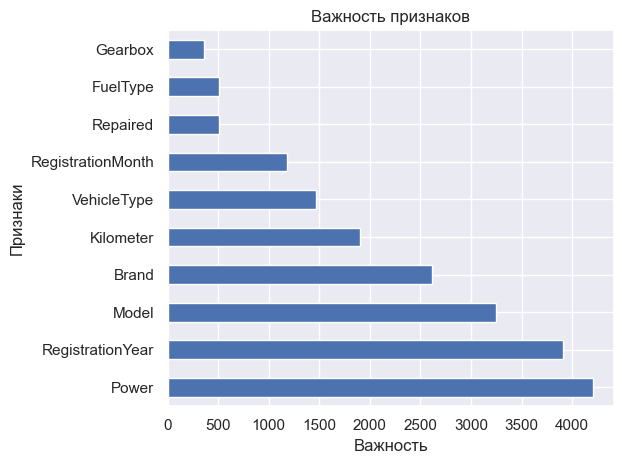

In [89]:
pd.Series(model_lgbmr.feature_importances_, features_train_te.columns).nlargest(10).plot(kind='barh')
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

**Исходя из полученных результатов можно сделать вывод:**

- Все значения метрик RMSE меньше 2500;
- Наименьшую ошибку на тесте выдает LightGBM;
- LightGBM лучшая модель по скорости;
- DesicionTree худшая модель и по скорости и по значению метрики;
- Основываясь на этом, можно сделать вывод, что лучше всего подойдет модель LightGBM.
- При помощи feature_importances_ выяснили, что самые важные признаки для модели Power, RegistrationYear и Model.